In [1]:
'''
=====Experiment=====
Dataset: UNSW-NB15 dataset

Training with whole graph
Downsampled 90% normal traffic randomly
Split train and test randomly

Combined IP and Port features
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.UNSW_NB15.UNSW_NB15_config import UNSW_NB15_Config

In [2]:
csv_file_name = "all_raw_downsampled"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"UNSW_NB15/All/{csv_file_name}.csv"))

DATASET_NAME = "UNSW_NB15"

SOURCE_IP_COL_NAME = UNSW_NB15_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = UNSW_NB15_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = UNSW_NB15_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = UNSW_NB15_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = UNSW_NB15_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = UNSW_NB15_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = UNSW_NB15_Config.BENIGN_CLASS_NAME

TIME_COLS = UNSW_NB15_Config.TIME_COL_NAMES

MULTICLASS = True
label_col = ATTACK_CLASS_COL_NAME if MULTICLASS else IS_ATTACK_COL_NAME

print(data[ATTACK_CLASS_COL_NAME].value_counts())
print(data[IS_ATTACK_COL_NAME].value_counts())

if MULTICLASS:
    data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
else:
    data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)

checkpoint_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, f"whole_graph_combined_ports/checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, f"whole_graph_combined_ports/best_model_{csv_file_name}.pth")

os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)

/tmp/ipykernel_1414208/3491705315.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(project_root, "Datasets", f"UNSW_NB15/All/{csv_file_name}.csv"))


attack_cat
Normal            221876
Generic           215481
Exploits           44525
Fuzzers            24246
DoS                16353
Reconnaissance     13987
Analysis            2677
Backdoor            1795
Shellcode           1511
Backdoors            534
Worms                174
Name: count, dtype: int64
label
1    321283
0    221876
Name: count, dtype: int64


In [3]:
data.drop(columns=UNSW_NB15_Config.DROP_COLS,inplace=True)
data.drop(columns=UNSW_NB15_Config.TIME_COL_NAMES)

,srcip,sport,dstip,dsport,state,dur,sbytes,dbytes,sttl,dttl,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat
0,10.40.85.1,0,224.0.0.5,0,INT,50.004341,384,0,1,0,...,0.0,0.0,2,4,4,2,2,4,2,Normal
1,59.166.0.6,2142,149.171.126.4,53,CON,0.001134,132,164,31,29,...,0.0,0.0,12,7,1,2,2,1,1,Normal
2,175.45.176.0,13284,149.171.126.16,80,FIN,2.390390,1362,268,254,252,...,0.0,0.0,5,2,2,1,1,1,1,Reconnaissance
3,59.166.0.3,42587,149.171.126.8,25,FIN,34.077175,37358,3380,31,29,...,0.0,0.0,1,1,12,10,1,1,2,Normal
4,10.40.170.2,0,10.40.170.2,0,INT,0.000000,46,0,0,0,...,0.0,0.0,2,2,2,2,2,2,2,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543154,175.45.176.0,47439,149.171.126.10,53,INT,0.000001,114,0,254,0,...,0.0,NaN,15,15,15,15,15,15,15,Generic
543155,175.45.176.0,47439,149.171.126.10,53,INT,0.000001,114,0,254,0,...,0.0,NaN,15,15,15,15,15,15,15,Generic
543156,59.166.0.5,53521,149.171.126.7,21,CON,1.086072,1940,2404,31,29,...,2.0,2.0,2,2,3,3,2,2,3,Normal
543157,175.45.176.0,17293,149.171.126.17,110,CON,0.942984,574,676,62,252,...,0.0,NaN,2,1,2,4,2,2,2,Exploits


In [4]:
data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

# # Combine Port and IP
data[SOURCE_PORT_COL_NAME] = data[SOURCE_PORT_COL_NAME].apply(str)
data[DESTINATION_PORT_COL_NAME] = data[DESTINATION_PORT_COL_NAME].apply(str)

data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME] + ':' + data[SOURCE_PORT_COL_NAME]
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME] + ':' + data[DESTINATION_PORT_COL_NAME]
data.drop(columns=[SOURCE_PORT_COL_NAME,DESTINATION_PORT_COL_NAME],inplace=True)

# data[SOURCE_PORT_COL_NAME] = pd.to_numeric(data[SOURCE_PORT_COL_NAME], errors='coerce').fillna(0).astype(int)
# data[DESTINATION_PORT_COL_NAME] = pd.to_numeric(data[DESTINATION_PORT_COL_NAME], errors='coerce').fillna(0).astype(int)

In [5]:
print(data.head)

<bound method NDFrame.head of                      srcip               dstip state        dur  sbytes  \
0             10.40.85.1:0         224.0.0.5:0   INT  50.004341     384   
1          59.166.0.6:2142    149.171.126.4:53   CON   0.001134     132   
2       175.45.176.0:13284   149.171.126.16:80   FIN   2.390390    1362   
3         59.166.0.3:42587    149.171.126.8:25   FIN  34.077175   37358   
4            10.40.170.2:0       10.40.170.2:0   INT   0.000000      46   
...                    ...                 ...   ...        ...     ...   
543154  175.45.176.0:47439   149.171.126.10:53   INT   0.000001     114   
543155  175.45.176.0:47439   149.171.126.10:53   INT   0.000001     114   
543156    59.166.0.5:53521    149.171.126.7:21   CON   1.086072    1940   
543157  175.45.176.0:17293  149.171.126.17:110   CON   0.942984     574   
543158  175.45.176.0:17293  149.171.126.17:110   CON   0.942984     574   

        dbytes  sttl  dttl  sloss  dloss  ...  is_ftp_login  ct_ftp_c

In [6]:
data = pd.get_dummies(data, columns = UNSW_NB15_Config.CATEGORICAL_COLS) # One Hot Encoding for categorical data
converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(UNSW_NB15_Config.CATEGORICAL_COLS))]

In [7]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of                      srcip               dstip        dur  sbytes  dbytes  \
0             10.40.85.1:0         224.0.0.5:0  50.004341     384       0   
1          59.166.0.6:2142    149.171.126.4:53   0.001134     132     164   
2       175.45.176.0:13284   149.171.126.16:80   2.390390    1362     268   
3         59.166.0.3:42587    149.171.126.8:25  34.077175   37358    3380   
4            10.40.170.2:0       10.40.170.2:0   0.000000      46       0   
...                    ...                 ...        ...     ...     ...   
543154  175.45.176.0:47439   149.171.126.10:53   0.000001     114       0   
543155  175.45.176.0:47439   149.171.126.10:53   0.000001     114       0   
543156    59.166.0.5:53521    149.171.126.7:21   1.086072    1940    2404   
543157  175.45.176.0:17293  149.171.126.17:110   0.942984     574     676   
543158  175.45.176.0:17293  149.171.126.17:110   0.942984     574     676   

        sttl  dttl  sloss  dloss         Sloa

In [8]:
scaler = StandardScaler()
cols_to_norm = UNSW_NB15_Config.COLS_TO_NORM
print(data[cols_to_norm].describe()) # Check if there's any too large value

                 dur        sbytes        dbytes           sttl  \
count  543159.000000  5.431590e+05  5.431590e+05  543159.000000   
mean        0.706760  5.136572e+03  1.936909e+04     157.197364   
std        12.637229  1.202311e+05  1.390925e+05     108.452474   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000007  1.140000e+02  0.000000e+00      31.000000   
50%         0.000011  2.000000e+02  0.000000e+00     254.000000   
75%         0.072088  1.580000e+03  1.940000e+03     254.000000   
max      8760.776367  1.435577e+07  1.465753e+07     255.000000   

                dttl          sloss          dloss         Sload  \
count  543159.000000  543159.000000  543159.000000  5.431590e+05   
mean       38.850764       3.800661       8.729770  6.877595e+07   
std        77.034389      45.616565      50.136204  1.420534e+08   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%         0.000000       0.000000       0.000000  3.70

In [9]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, UNSW_NB15_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [10]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [11]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)


['Analysis' 'Backdoor' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic'
 'Normal' 'Reconnaissance' 'Shellcode' 'Worms']
Attack label mapping: {'Analysis': 0, 'Backdoor': 1, 'Backdoors': 2, 'DoS': 3, 'Exploits': 4, 'Fuzzers': 5, 'Generic': 6, 'Normal': 7, 'Reconnaissance': 8, 'Shellcode': 9, 'Worms': 10}


In [12]:
# 70% train, 15% validation, 15% test
train_full_df, test_df = train_test_split(
     data, test_size=0.15, random_state=42, stratify=data[label_col])


# # Maintain the order of the rows in the original dataframe
# train_full_df = train_full_df.sort_values(by=UNSW_NB15_Config.TIME_COL_NAMES)
# test_df = test_df.sort_values(by=UNSW_NB15_Config.TIME_COL_NAMES)

feature_cols = UNSW_NB15_Config.COLS_TO_NORM + converted_categorical_cols

print('Feature Columns:', feature_cols)

train_full_df['h'] = train_full_df[ feature_cols ].values.tolist()
test_df['h'] = test_df[ feature_cols ].values.tolist()

# X_train = train_full_df.drop(columns=[label_col])
# X_val = val_df.drop(columns=[label_col])
# X_test = test_df.drop(columns=[label_col])

y_train = train_full_df[label_col]
y_test = test_df[label_col]

pd.set_option('display.max_columns', None)

print("Number of training samples:", len(train_full_df))
print(y_train.value_counts())
print("Number of test samples:", len(test_df))
print(y_test.value_counts())

print(train_full_df.head(5))

Feature Columns: ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'state_ACC', 'state_CLO', 'state_CON', 'state_ECO', 'state_FIN', 'state_INT', 'state_MAS', 'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD', 'state_URH']
Number of training samples: 461685
attack_cat
7     188595
6     183159
4      37846
5      20609
3      13900
8      11889
0       2275
1       1526
9       1284
2        454
10       148
Name: count, dtype: int64
Number of test samples: 81474
attack_cat
7     33281
6     32322
4      6679
5      3637
3      2453
8      2098
0       402
1       269
9       227

In [13]:
def create_graph(df, source_ip_col, destination_ip_col, edge_attr, create_using=nx.MultiDiGraph(), **kwargs):
    G_nx = nx.from_pandas_edgelist(df, source_ip_col, destination_ip_col, edge_attr, create_using=create_using, **kwargs)
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    print("Number of edges in G_pyg:", num_edges)
    print("Number of node in G_pyg:", num_nodes)
    print("Shape of node in G_pyg:", G_pyg.x.shape)
    print("Shape of edge attr in G_pyg:", G_pyg.edge_attr.shape)
    print("Shape of edge label in G_pyg:", G_pyg.edge_label.shape)

    return G_nx, G_pyg

In [14]:
G_nx_test, G_pyg_test = create_graph(test_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

Number of edges in G_pyg: 81474
Number of node in G_pyg: 52521
Shape of node in G_pyg: torch.Size([52521, 51])
Shape of edge attr in G_pyg: torch.Size([81474, 51])
Shape of edge label in G_pyg: torch.Size([81474])


In [15]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [16]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
th.cuda.empty_cache()

In [18]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(data, epochs, learning_rates, hidden_dims, drop_outs):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds = []
    for train_idx, val_idx in skf.split(data, data[label_col]):
        train_df = data.iloc[train_idx]
        val_df = data.iloc[val_idx]

        G_nx_train, G_pyg_train = create_graph(train_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
        G_nx_val, G_pyg_val = create_graph(val_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

        G_pyg_train = G_pyg_train.to(device)
        G_pyg_val = G_pyg_val.to(device)

        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
        G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

        folds.append((G_pyg_train, G_pyg_val))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}")
                fold_f1_scores = []

                for fold, (G_pyg_train, G_pyg_val) in enumerate(folds):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=G_pyg_train.num_node_features,
                                    edge_in_channels=G_pyg_train.num_edge_features,
                                    hidden_channels=hidden_dim,
                                    dropout=drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    labels = G_pyg_train.edge_label.cpu().numpy()
                    class_weights = class_weight.compute_class_weight('balanced',
                                                                    classes=np.unique(labels),
                                                                    y=labels)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        train_loss = 0
                        val_loss = 0

                        try:
                            model.train()
                            out = model(G_pyg_train)
                            
                            optimizer.zero_grad()
                            loss = criterion(out, G_pyg_train.edge_label)
                            train_loss = loss.item()

                            loss.backward()
                            optimizer.step()

                            model.eval()
                            with th.no_grad():
                                out = model(G_pyg_val)
                                loss = criterion(out, G_pyg_val.edge_label)
                                val_loss = loss.item()

                            val_f1 = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='weighted')

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Parameters: lr={lr}, hidden_dim{hidden_dim}, drop_out={drop_out}")

                            if epoch % 100 == 0:
                                print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print("Current Results: ", params_results)
                print(f"Average F1 Score for dropout {drop_out} learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

        print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
        print("All results:", params_results)


learning_rates = [0.001, 0.005, 0.01]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

# grid_search(train_full_df, epochs=100, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


Number of edges in G_pyg: 307790
Number of node in G_pyg: 182726
Shape of node in G_pyg: torch.Size([182726, 51])
Shape of edge attr in G_pyg: torch.Size([307790, 51])
Shape of edge label in G_pyg: torch.Size([307790])
Number of edges in G_pyg: 153895
Number of node in G_pyg: 96060
Shape of node in G_pyg: torch.Size([96060, 51])
Shape of edge attr in G_pyg: torch.Size([153895, 51])
Shape of edge label in G_pyg: torch.Size([153895])
Number of edges in G_pyg: 307790
Number of node in G_pyg: 182512
Shape of node in G_pyg: torch.Size([182512, 51])
Shape of edge attr in G_pyg: torch.Size([307790, 51])
Shape of edge label in G_pyg: torch.Size([307790])
Number of edges in G_pyg: 153895
Number of node in G_pyg: 96341
Shape of node in G_pyg: torch.Size([96341, 51])
Shape of edge attr in G_pyg: torch.Size([153895, 51])
Shape of edge label in G_pyg: torch.Size([153895])
Number of edges in G_pyg: 307790
Number of node in G_pyg: 182467
Shape of node in G_pyg: torch.Size([182467, 51])
Shape of edge 

In [20]:
train_df, val_df = train_test_split(
     train_full_df, test_size=0.15, random_state=42, stratify=train_full_df[label_col])

G_nx_train, G_pyg_train = create_graph(train_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
G_nx_val, G_pyg_val = create_graph(val_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())


Number of edges in G_pyg: 392432
Number of node in G_pyg: 226626
Shape of node in G_pyg: torch.Size([226626, 51])
Shape of edge attr in G_pyg: torch.Size([392432, 51])
Shape of edge label in G_pyg: torch.Size([392432])
Number of edges in G_pyg: 69253
Number of node in G_pyg: 44952
Shape of node in G_pyg: torch.Size([44952, 51])
Shape of edge attr in G_pyg: torch.Size([69253, 51])
Shape of edge label in G_pyg: torch.Size([69253])


In [21]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    # plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.plot(val_f1, label='Validation F1', color='green')
    plt.scatter(saved_model_epochs, [val_f1[epoch] for epoch in saved_model_epochs], color='red', label='Saved Model', zorder=5)
    plt.title('Train and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid()
    plt.show()

In [24]:

# Extract the best parameters from the grid search
best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.001  # Replace with the best learning_rate found
best_dropout = 0.3  # Replace with the best dropout found

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=G_pyg_train.num_node_features,
                   edge_in_channels=G_pyg_train.num_edge_features,
                   hidden_channels=best_hidden_dim,
                   dropout=best_dropout,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Compute class weights for the training dataset
labels = G_pyg_train.edge_label.cpu().numpy()
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)

# Normalize class weights
class_weights = th.FloatTensor(class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)

# Move the graph data to the device
G_pyg_train = G_pyg_train.to(device)
G_pyg_val = G_pyg_val.to(device)

G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

best_f1 = 0

# Load checkpoint if exists
start_epoch = 0
epochs = 1000

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

for epoch in range(start_epoch, epochs):
    train_loss = 0
    val_loss = 0

    model.train()
    out = model(G_pyg_train)

    optimizer.zero_grad()
    loss = criterion(out, G_pyg_train.edge_label)
    train_loss = loss.item()

    loss.backward()
    optimizer.step()

    model.eval()
    with th.no_grad():
        out = model(G_pyg_val)
        loss = criterion(out, G_pyg_val.edge_label)
        val_loss = loss.item()

    val_f1 = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='weighted')

    if epoch % 10 == 0 or val_f1 > best_f1:
        # Save checkpoint
        th.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_f1': best_f1
        }, checkpoint_path)

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)
        saved_model_epochs.append(epoch)

    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append(val_f1)

# Save the trained model
print("Model training completed and saved.")

Class weights: tensor([1.8447e+01, 2.7506e+01, 9.2424e+01, 3.0195e+00, 1.1090e+00, 2.0366e+00,
        2.2915e-01, 2.2255e-01, 3.5301e+00, 3.2700e+01, 2.8314e+02],
       device='cuda:0')
Resumed training from epoch 33
Epoch 33 Saved best model. Best F1: 0.8819925129967131
Epoch 33, Train Loss: 1.2345, Validation Loss: 1.6728, Validation F1: 0.8820
Epoch 34, Train Loss: 1.1682, Validation Loss: 1.6842, Validation F1: 0.8783
Epoch 35, Train Loss: 1.2187, Validation Loss: 1.7162, Validation F1: 0.8802
Epoch 36, Train Loss: 1.1892, Validation Loss: 1.7086, Validation F1: 0.8769
Epoch 37, Train Loss: 1.1777, Validation Loss: 1.7755, Validation F1: 0.8778
Epoch 38, Train Loss: 1.1583, Validation Loss: 1.5798, Validation F1: 0.8780
Epoch 39, Train Loss: 1.1415, Validation Loss: 1.6470, Validation F1: 0.8752
Epoch 40, Train Loss: 1.1930, Validation Loss: 1.6558, Validation F1: 0.8804
Epoch 41 Saved best model. Best F1: 0.8839981468763695
Epoch 41, Train Loss: 1.1473, Validation Loss: 1.6802, 

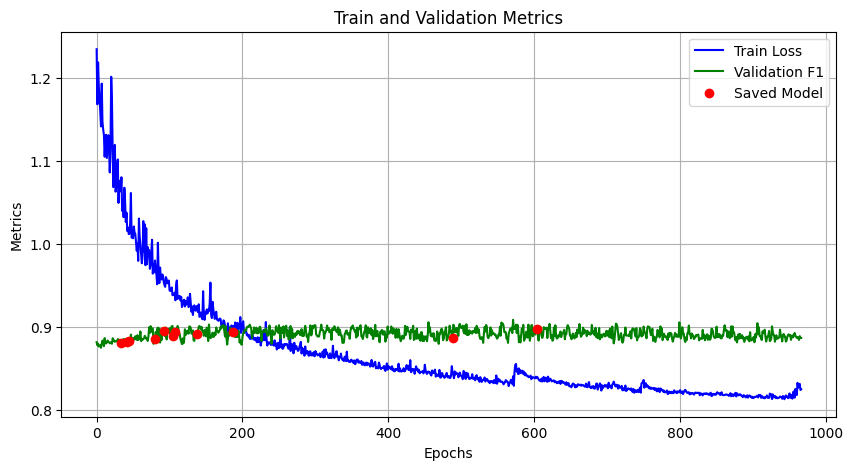

In [25]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

In [26]:
G_nx_test, G_pyg_test = create_graph(test_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

Number of edges in G_pyg: 81474
Number of node in G_pyg: 52521
Shape of node in G_pyg: torch.Size([52521, 51])
Shape of edge attr in G_pyg: torch.Size([81474, 51])
Shape of edge label in G_pyg: torch.Size([81474])


In [27]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(G_pyg_test, adversarial=False):

    G_pyg_test = G_pyg_test.to(device)
    G_pyg_test.edge_label = G_pyg_test.edge_label.to(device)
    G_pyg_test.edge_attr = G_pyg_test.edge_attr.to(device)

    best_model = EGraphSAGE(node_in_channels=G_pyg_test.num_node_features, 
                       edge_in_channels=G_pyg_test.num_edge_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path))
    best_model = best_model.to(device)

    best_model.eval()

    print("inference start")
    with th.no_grad():
            
        try:
            out = best_model(G_pyg_test)
            
        except Exception as forward_error:
            print(f"Error during forward/backward pass at {forward_error}")

    print("inference done")

    # test_accuracy = compute_accuracy(out, G_pyg_test.edge_label)
    # print(f'Test Accuracy: {test_accuracy:.4f}')
    
    pred_labels = out.argmax(dim=1).cpu()
    all_test_labels = G_pyg_test.edge_label.cpu()

    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]
        
        

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4)
    print(report)

    
eval(G_pyg_test)


Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/whole_graph_combined_ports/best_model_all_raw_downsampled.pth
inference start
inference done
class_map ['Analysis' 'Backdoor' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic'
 'Normal' 'Reconnaissance' 'Shellcode' 'Worms']
[[  208     0     0    73     2    62     0     0     0     0    57]
 [  116    17     1    98     2    19     0     0     0    10     6]
 [    0     3     1     0     0    73     0     0     0     1     2]
 [ 1095    25     0   642   142   220    12     2     1    63   251]
 [ 1546    90     2   727  1991   467    23     5    12   206  1610]
 [  198     5     0    90    62  2940     0    95     0    68   179]
 [  172    19     0   117   165    47 31450     2     3    41   306]
 [   16     8     0     0    19   360     0 32818     1    15    44]
 [  214     1     0   102     4    24     4     0  1431    14   304]
 [    0     1     0     0     3     0     0     0     1

In [28]:
# def confusion_matrix_plot(cm, all_test_labels, pred_labels):
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_map, yticklabels=class_map)
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.title("Confusion Matrix")

#     # Compute metrics
#     accuracy = accuracy_score(all_test_labels, pred_labels)
#     precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_test_labels, pred_labels, average='macro', zero_division=0)
#     precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_test_labels, pred_labels, average='weighted', zero_division=0)


#     metrics_text = (
#         f"Accuracy: {accuracy:.4f}\n"
#         f"Macro Precision: {precision_macro:.4f}\n"
#         f"Macro Recall: {recall_macro:.4f}\n"
#         f"Macro F1: {f1_macro:.4f}\n"
#         f"Weighted Precision: {precision_weighted:.4f}\n"
#         f"Weighted Recall: {recall_weighted:.4f}\n"
#         f"Weighted F1: {f1_weighted:.4f}"
#     )

#     # Position: bottom left corner of plot area
#     plt.gcf().text(0.02, 0.02, metrics_text, fontsize=12, va='bottom', ha='left',
#                 bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

#     plt.show()

In [36]:
def inject_traffic_to_attacker(graph, ratio=0.1, num_injected_nodes=1, is_attack=False):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # 1. Identify attacker nodes
    attacker_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
    attacker_nodes = th.unique(edge_index[:, attacker_edges])
    if attacker_nodes.numel() == 0:
        raise ValueError("No attacker nodes found.")

    # 2. Sample benign edge feature pool
    if is_attack:
        attack_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[attack_edges]
    else:
        benign_edges = (edge_label == BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[benign_edges]

    # 3. Inject new nodes
    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes

        dst = attacker_nodes[random.randint(0, len(attacker_nodes) - 1)].item()

        new_edges.append([src, dst])
        attr = inject_edge_attr_pool[random.randint(0, len(inject_edge_attr_pool) - 1)]
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

        # new_graph.first_injected_node_idx = original_num_nodes # Store injected node indices

    return new_graph


In [37]:
# Inject Attack Traffic to Attacker Nodes
G_pyg_test = G_pyg_test.cpu()
injected_graph = inject_traffic_to_attacker(G_pyg_test, 0.1, num_injected_nodes=1, is_attack=True)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/whole_graph_combined_ports/best_model_all_raw_downsampled.pth
inference start
inference done
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [  34  129   10  230  677  361 5381  237  253  825   10    0]]
class_map ['Analysi

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [38]:
# Inject BENIGN Traffic to Attacker Nodes
injected_graph = inject_traffic_to_attacker(G_pyg_test, 0.1, num_injected_nodes=1, is_attack=False)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/whole_graph_combined_ports/best_model_all_raw_downsampled.pth
inference start
inference done
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   3   39    1   53  125    8    2 7849    4   61    2    0]]
class_map ['Analysi

In [39]:
def inject_random_nodes(graph, ratio=0.1, num_injected_nodes=1):
	edge_index = graph.edge_index.clone()
	edge_attr = graph.edge_attr.clone()
	edge_label = graph.edge_label.clone()
	x = graph.x.clone()

	num_edges = edge_index.size(1)
	feature_dim = graph.x.size(1)

	# 1. Inject new nodes
	original_num_nodes = x.size(0)
	new_node_feats = th.ones((num_injected_nodes, feature_dim))
	x = th.cat([x, new_node_feats], dim=0)

	# 2. Inject random edges
	num_to_inject = max(1, int(ratio * num_edges))
	new_edges = []
	new_attrs = []
	new_labels = []

	for _ in range(num_to_inject):
		src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
		dst = random.randint(0, original_num_nodes - 1)  # to existing nodes

		new_edges.append([src, dst])
		attr = edge_attr[random.randint(0, len(edge_attr) - 1)]  # Randomly sample edge attributes
		new_attrs.append(attr)
		new_labels.append(ADVERSARIAL_CLASS_LABEL)  # Assign benign class label to new edges

	# 3. Merge into graph
	if new_edges:
		new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
		new_attrs = th.stack(new_attrs)
		new_labels = th.tensor(new_labels, dtype=th.long)

		edge_index = th.cat([edge_index, new_edges], dim=1)
		edge_attr = th.cat([edge_attr, new_attrs], dim=0)
		edge_label = th.cat([edge_label, new_labels], dim=0)

	# Create a new graph with the injected nodes and edges
	new_graph = Data(
		edge_index=edge_index,
		edge_attr=edge_attr,
		edge_label=edge_label,
		x=x
	)

	return new_graph

In [40]:
# Inject Random Nodes in the graph
injected_graph = inject_random_nodes(G_pyg_test, 0.1, num_injected_nodes=1)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/whole_graph_combined_ports/best_model_all_raw_downsampled.pth
inference start
inference done
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [  18   93    8   74  368  166 2206 4546   36  614   18    0]]
class_map ['Analysi